### Imports

In [1]:
import torch
import torch_geometric
import torch.nn as nn
import explainer
import networks
import datasetLoader
import evaluation
import importlib
import matplotlib.pyplot as plt
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
import networkx as nx
from typing import Literal
import torch.nn.functional as fn
from torch_geometric.utils import k_hop_subgraph
import utils
from torch_geometric.utils import to_undirected
import wandb
import random

importlib.reload(datasetLoader)
importlib.reload(networks)
importlib.reload(explainer)
importlib.reload(utils)
importlib.reload(evaluation)

KeyboardInterrupt: 

### Parameters Explainer

In [ ]:
batch_size = 1
sampled_graphs = 20

learning_rate_mlp = 0.003       #Paper: 0.003,
coefficientSizeReg = 1.0       #Paper: 0.05, code 0, codePyG 1.0
entropyReg = 1.0               #Paper: 1, code 0, codePyG 1.0
epochs_mlp = 30                 #Paper: 30 for all datasets => 20 enough for BA2Motif
coefficientL2Reg = 0.0
# TODO: Budget, connectivity

# Temperature
t_0 =  5.0
t_T = 2.0                       #Paper says 2.0, Code seems to use 1.0 => 1.0 seems to work good

datasetName: Literal['BA-Shapes', 'BA-Community', 'Tree-Cycles', 'Tree-Grid'] = 'Tree-Grid'

## Visualize Data TODO: NodePlot function

tensor([False, False, False,  ...,  True,  True,  True])


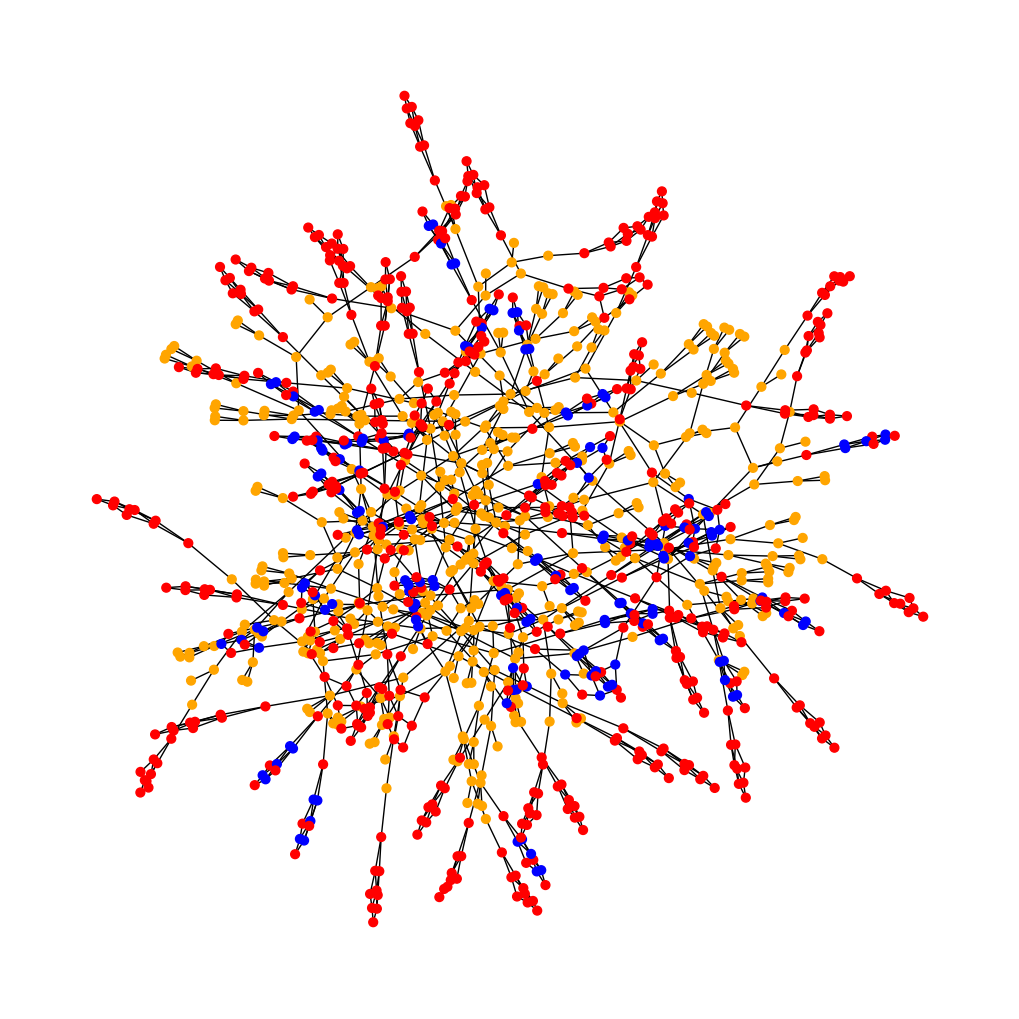

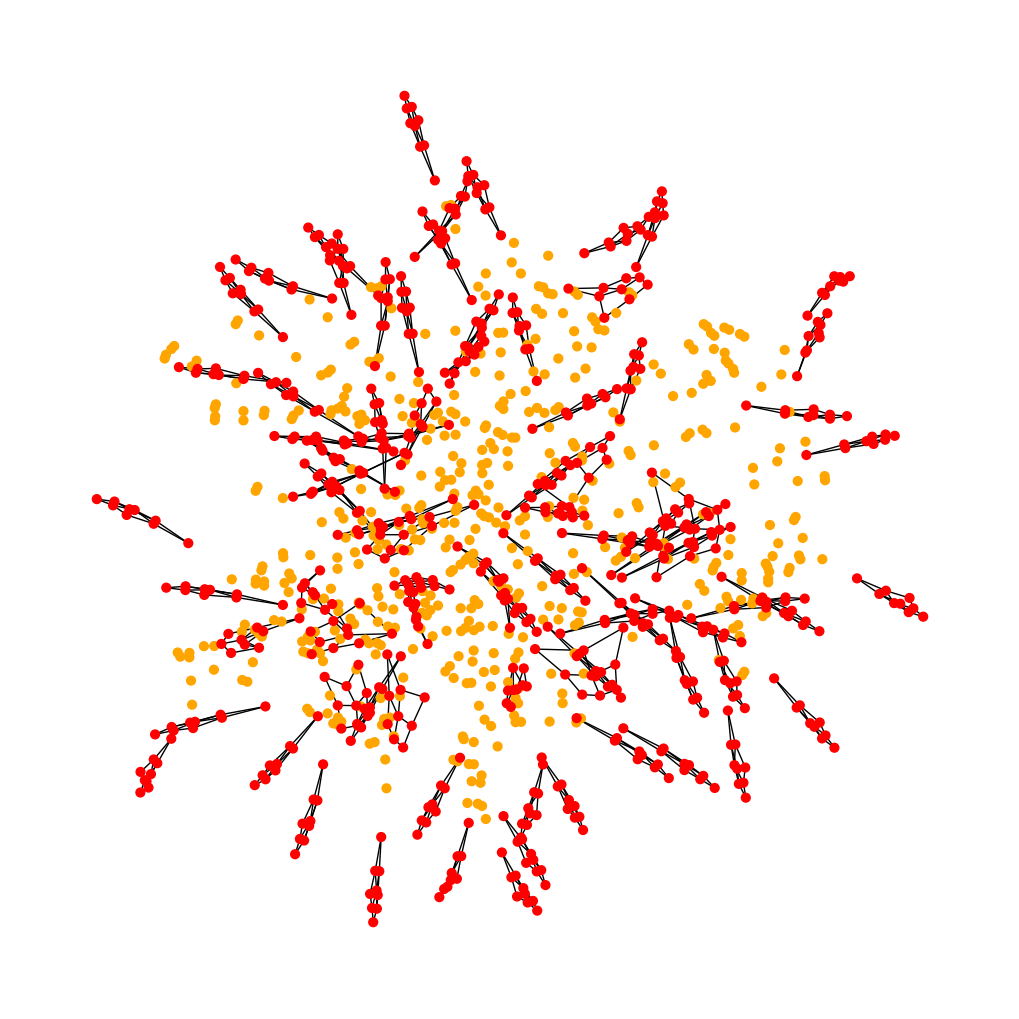

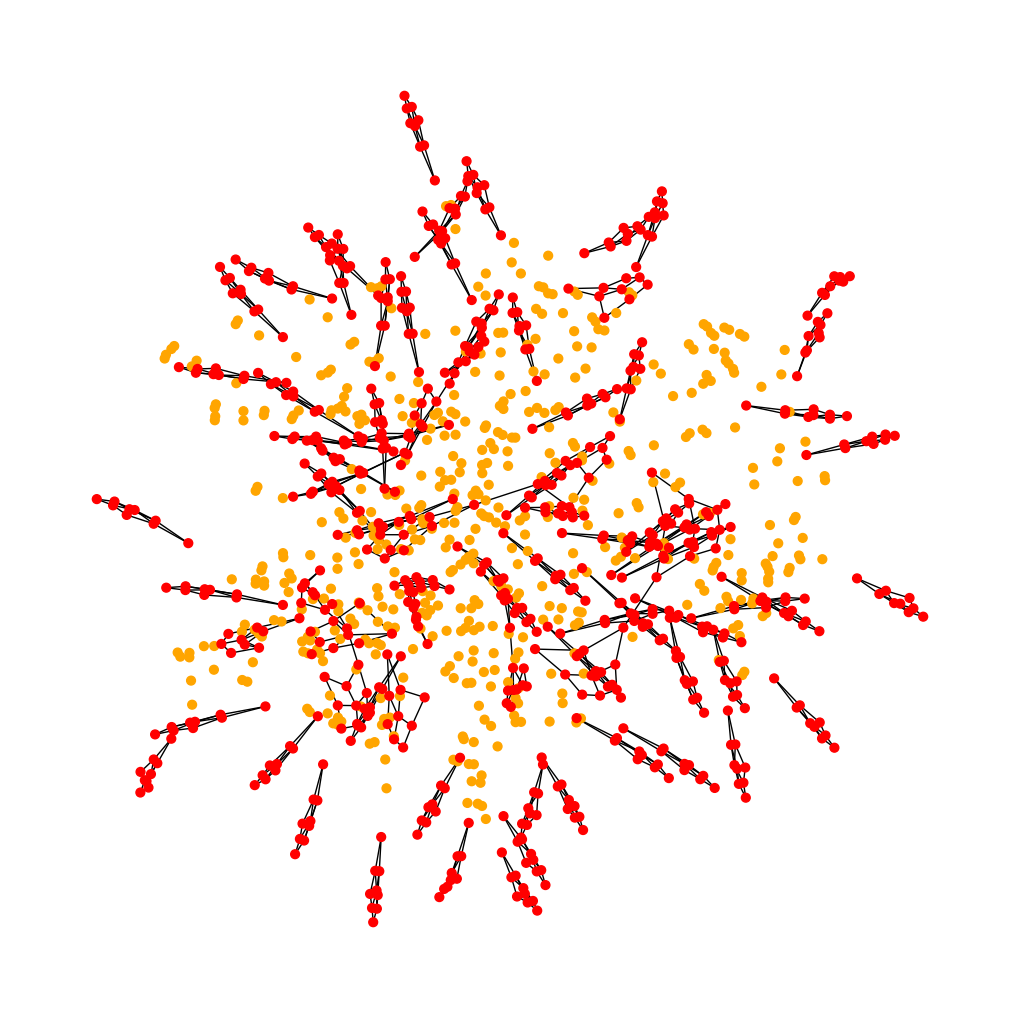

In [20]:
#labels, data = datasetLoader.loadNodeDataset(datasetName)

data, num_labels = datasetLoader.loadOriginalNodeDataset(datasetName)

print(data.gt_mask)

ground_truth_indices = []
allLabels = data.y

for index in range(0, len(data.edge_index[0])):
    if allLabels[data.edge_index[0][index]] == 1 and allLabels[data.edge_index[1][index]] == 1:
        ground_truth_indices.append(index)
        
groundTruthMask = torch.zeros_like(data.edge_index[0], dtype=torch.bool)
groundTruthMask[ground_truth_indices] = 1

edge_index_masked = data.edge_index[:,groundTruthMask]

data1 = Data(x=data.x, y=data.y, edge_index=data.edge_index[:,data.gt_mask])
data2 = Data(x=data.x, y=data.y, edge_index=edge_index_masked)

motifNodesOriginal = [i for i in range(511,800,9)]              #in(512,514,515,516,518) out(511,513, 517,519)                   range(511,800,1)
motifNodesNew = [i for i in range(len(data.x)) if data.y[i] == 1 ]
allNodes = [i for i in range(len(data.x))]

# motifNodesModified is supposed to only contain the "middle" elements of the motif, for which the 3-hop graph contains the complete motif 
motifNodesModified = [i for i in range(512,800,9)]
trainableNodes = [514, 515, 516, 518]

motifNodesMinimal = [i for i in range(512,800,9)]
motifNodesMinimal.extend([i for i in range(514,800,9)])
motifNodesMinimal = sorted(set(motifNodesMinimal))

def add_multiples_of_9(start, end=800, step=9):
    return [i for i in range(start, end, step)]

for element in trainableNodes:
    motifNodesModified.extend(add_multiples_of_9(element))
    
motifNodesModified = sorted(set(motifNodesModified))

pos = utils.plotTreeCycles(data, node_list=motifNodesModified)
pos1 = utils.plotTreeCycles(data1, pos=pos)
pos2 = utils.plotTreeCycles(data2, pos=pos)

#motifNodesOriginal = [i for i in range(511,800,1)]

#data3 = Data()

#pos3 = utils.plotTreeCycles(data3, pos=pos)

### Load GNN model

In [21]:
modelNodeGNN = networks.NodeGNN(features = data.x.shape[1], labels=num_labels)     # Adjust according to data and task
modelNodeGNN.load_state_dict(torch.load("models/TreeGrid 99 layerNorm latest", weights_only=True))

<All keys matched successfully>

## RandomAUCNode for evaluation during training. CHANGE

In [5]:
randomAUCNode = torch.randint(511, 880+1, [1]).item()

#[i for i in range(a[0],len(a),6)]
print(randomAUCNode)

584


In [22]:
motifNodes = motifNodesOriginal

### Training Loop Graph Classification Explainer

In [23]:
#torch.set_printoptions(threshold=10_000)
wandb.init(
    # set the wandb project where this run will be logged
    project="Explainer-Training",

    # track hyperparameters and run metadata
    config={
    "learning_rate": learning_rate_mlp,
    "architecture": "MLP",
    "dataset": datasetName,
    "epochs": epochs_mlp,
    "#sampled_graphs": sampled_graphs,
    "size_regularization": coefficientSizeReg,
    "entropy_regularization": entropyReg,
    "L2_regularization": coefficientL2Reg,
    "initial_temperature": t_0,
    "final_temperature": t_T,
    }
)

mlp = explainer.MLP(GraphTask=False, hidden_dim=64)

wandb.watch(mlp, log= "all", log_freq=2, log_graph=False)

mlp_optimizer = torch.optim.Adam(params = mlp.parameters(), lr = learning_rate_mlp, maximize=False)

modelNodeGNN.eval()
for param in modelNodeGNN.parameters():
    param.requires_grad = False

for epoch in range(0, epochs_mlp) :
    mlp.train()
    mlp_optimizer.zero_grad()

    temperature = t_0*((t_T/t_0) ** ((epoch+1)/epochs_mlp))

    # Iterate over first motif NODES in data
    #for node_index, nodeFeatures in enumerate(data.x):
    for node_index in motifNodes:
        #Calculate k-hop graph for node
        subset, edge_index_hop, mapping, edge_mask = k_hop_subgraph(node_idx=node_index, num_hops=3, edge_index=data.edge_index, relabel_nodes=False)
        
        # Get index for node to predict in subset, since edge_index is relabeled to match features
        #indexNodeToPred = (subset == node_index).nonzero().item()
        
        # MLP forward                                                           # shape embeddings[batch_index]: ~50 X 60 = Edges X hidden_embs_3Nodes
        w_ij = mlp.forward(modelGraphGNN=modelNodeGNN, x=data.x, edge_index=edge_index_hop, nodeToPred=node_index)               # shape: ~50 X 1 = Edges X MLP_out(edge_weight)

        sampleLoss = torch.FloatTensor([0])
        loss = torch.FloatTensor([0])
        
        for k in range(0, sampled_graphs):
            # Sample with reparam trick via edge weights
            edge_ij = mlp.sampleGraph(w_ij, temperature)

            # TODO: This softmax is needed for the prediction of the downstream task and should probably be moved into the GNN model!!!
            # until then it is def needed here. Probably correct here, can also be found in og Explainer.call
            # TODO: Hpw do I calc loss? Between k-hop graph and original graph not possible. Only take node_idx from original and sampled?
            pOriginal = fn.softmax(modelNodeGNN.forward(data.x, edge_index_hop), dim=1)
            pSample = fn.softmax(modelNodeGNN.forward(data.x, edge_index_hop, edge_weights=edge_ij), dim=1)

            # TODO: VALIDATE pOriginal and pSample pass both label predictions, not just correct one
            currLoss = mlp.loss(pOriginal[node_index], pSample[node_index], edge_ij, coefficientSizeReg, entropyReg, coefficientL2Reg)        #pOriginal[indexNodeToPred]
            sampleLoss += currLoss
        
        loss += sampleLoss / sampled_graphs
        
    loss = loss / len(motifNodes)
    
    loss.backward()
    
    #Loss = Loss / len(train_loader.dataset)

    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

    torch.nn.utils.clip_grad_norm_(mlp.parameters(), max_norm=2)           # clip value min -2

    mlp_optimizer.step()

    mlp.eval()
    
    
    aucList = []
    for i in motifNodesModified:
        currAuc = evaluation.evaluateNodeExplainerAUC(mlp, modelNodeGNN, data, i, k=12)
        if currAuc != -1: aucList.append(currAuc)
    meanAuc = torch.tensor(aucList).mean().item()
    
    wandb.log({"train/Loss": loss, "train/mean_AUC": meanAuc})
    
    """out = mlp.forward(modelNodeGNN, data.x, data.edge_index, randomAUCNode)

    print(f"MLP Output for first val graph in epoch {epoch+1}:")
    print(out)"""

    """for name, param in mlp.named_parameters():
        if param.requires_grad:
            print(f"{name}: {param.grad}")"""
            
wandb.finish()

Epoch 1, Loss: 0.5452107787132263
AUC of ROC: 1.0
BinaryAUROC: 1.0
roc_auc_score: 1.0
AUC of ROC: 1.0
BinaryAUROC: 1.0
roc_auc_score: 1.0
AUC of ROC: 0.4583333432674408
BinaryAUROC: 0.4583333333333333
roc_auc_score: 0.4583333333333333
AUC not computable
AUC not computable
AUC of ROC: 1.0
BinaryAUROC: 1.0
roc_auc_score: 1.0
AUC of ROC: 1.0
BinaryAUROC: 1.0
roc_auc_score: 1.0
AUC of ROC: 0.4583333432674408
BinaryAUROC: 0.4583333333333333
roc_auc_score: 0.4583333333333333
AUC not computable
AUC not computable
AUC of ROC: 1.0
BinaryAUROC: 1.0
roc_auc_score: 1.0
AUC of ROC: 1.0
BinaryAUROC: 1.0
roc_auc_score: 1.0
AUC of ROC: 0.4583333432674408
BinaryAUROC: 0.4583333333333333
roc_auc_score: 0.4583333333333333
AUC not computable
AUC not computable
AUC of ROC: 0.7055555582046509
BinaryAUROC: 0.7055555555555556
roc_auc_score: 0.7055555555555556
AUC of ROC: 0.8583333492279053
BinaryAUROC: 0.8583333333333333
roc_auc_score: 0.8583333333333333
AUC of ROC: 0.6428571343421936
BinaryAUROC: 0.642857142

train/Loss,██▇▇▇▇▆▆▆▅▅▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁
train/mean_AUC,▁▁▁▇▇▇▇▇▇▇████████████████████
train/Loss,0.02266
train/mean_AUC,0.98249


### TODO: Evaluate AUC for "start node" of each motif: [i for i in range(511,871,6)]

In [196]:
randomAUCNode = random.choice(motifNodesModified)
currentAUC = randomAUCNode

### PROBLEM: Mask predicts 1 for each node, not only motif nodes! Stop weights from growing that huge, grad clipping?

tensor([-19.8316, -19.8316, -19.8316, -19.8316, -18.4260, -19.8316, -19.8316,
        -18.4260,  -9.7102,  -9.7102,  -9.7102,  -7.0453,  -8.5995,  -7.0453,
         -7.5022,  -9.7102,  -8.5995,  -7.0453,  -8.5995,  -8.5995,  -9.0564,
         -9.0564,  -7.5022,  -9.0564,  -7.9731,  -7.0453,  -7.5022,  -9.0564,
         -7.5022,  -7.9731,  -7.9731,  -7.9731], grad_fn=<CopySlices>)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([False, False, False, False, False, False, False, False,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True])
AUC of ROC: 1.0
BinaryAUROC: 1.0
roc_auc_score: 1.0
1.0


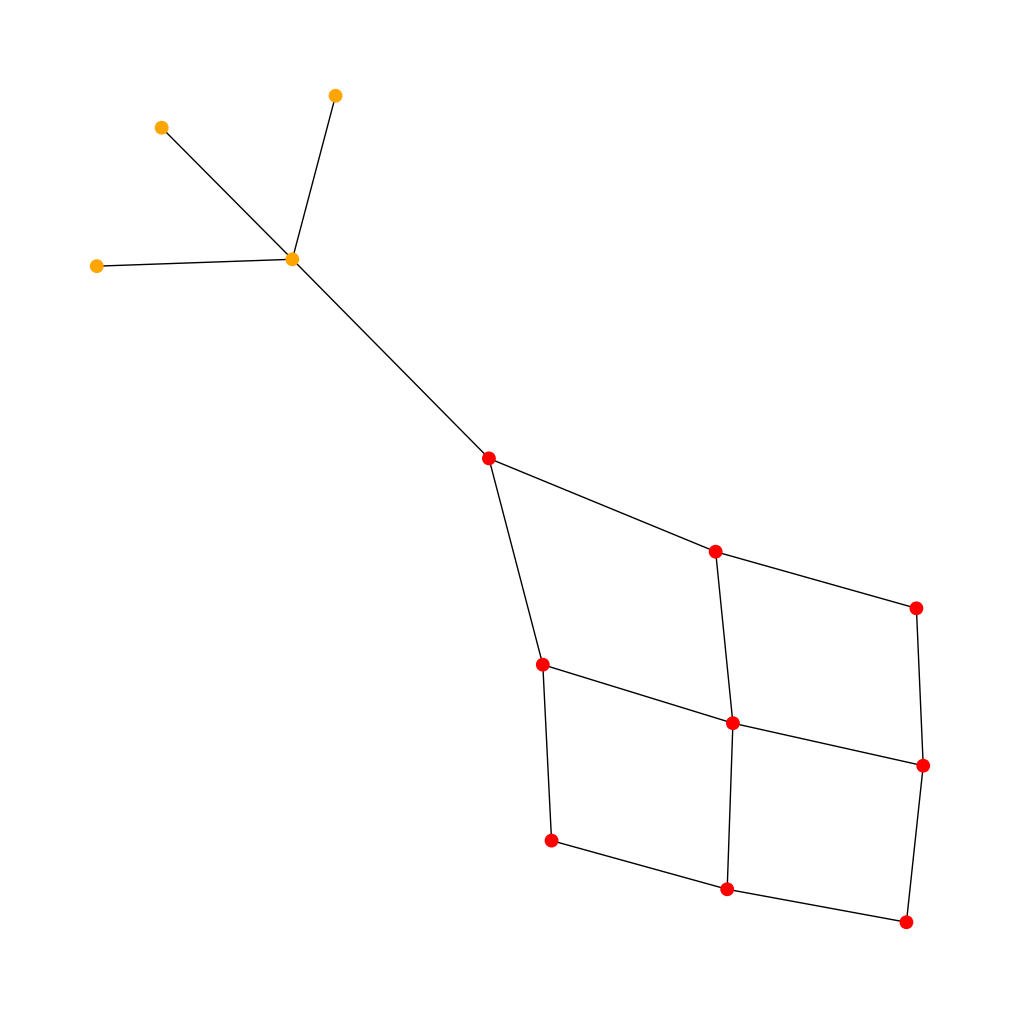

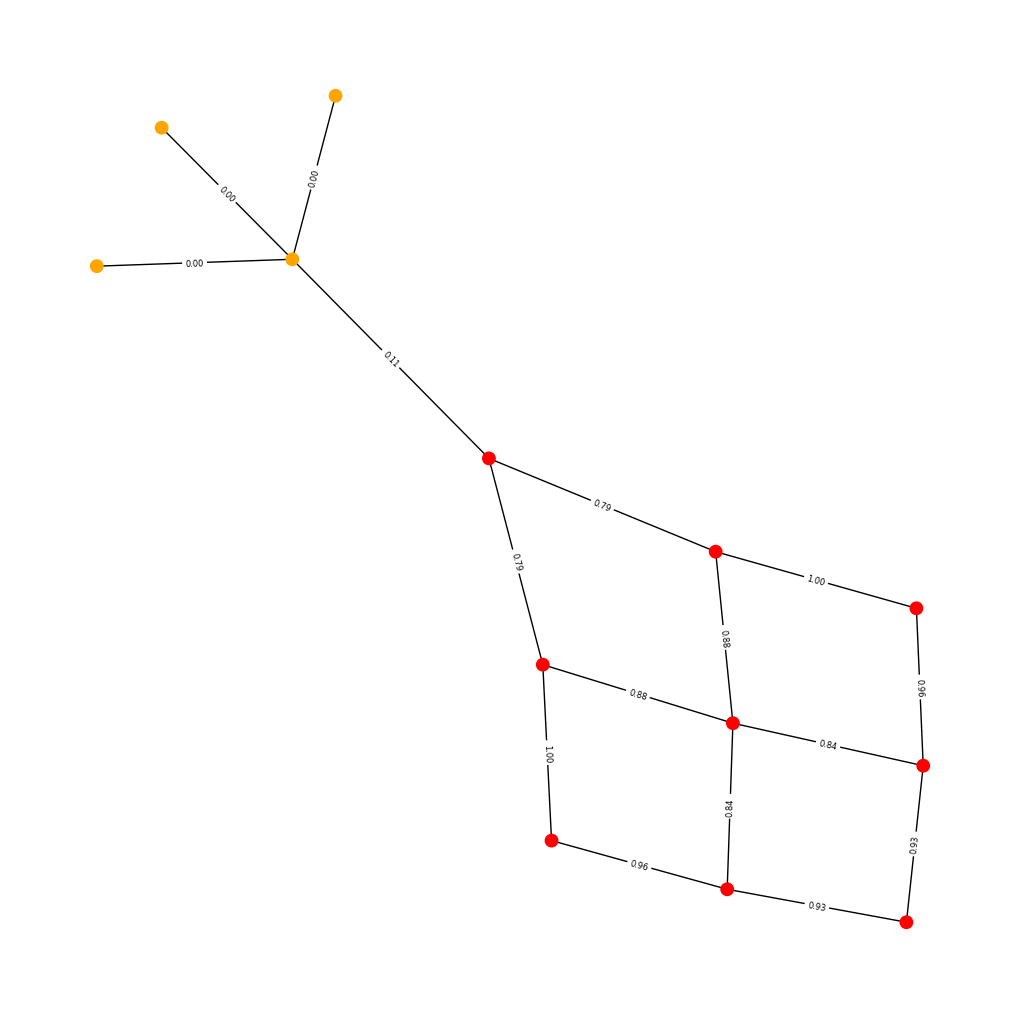

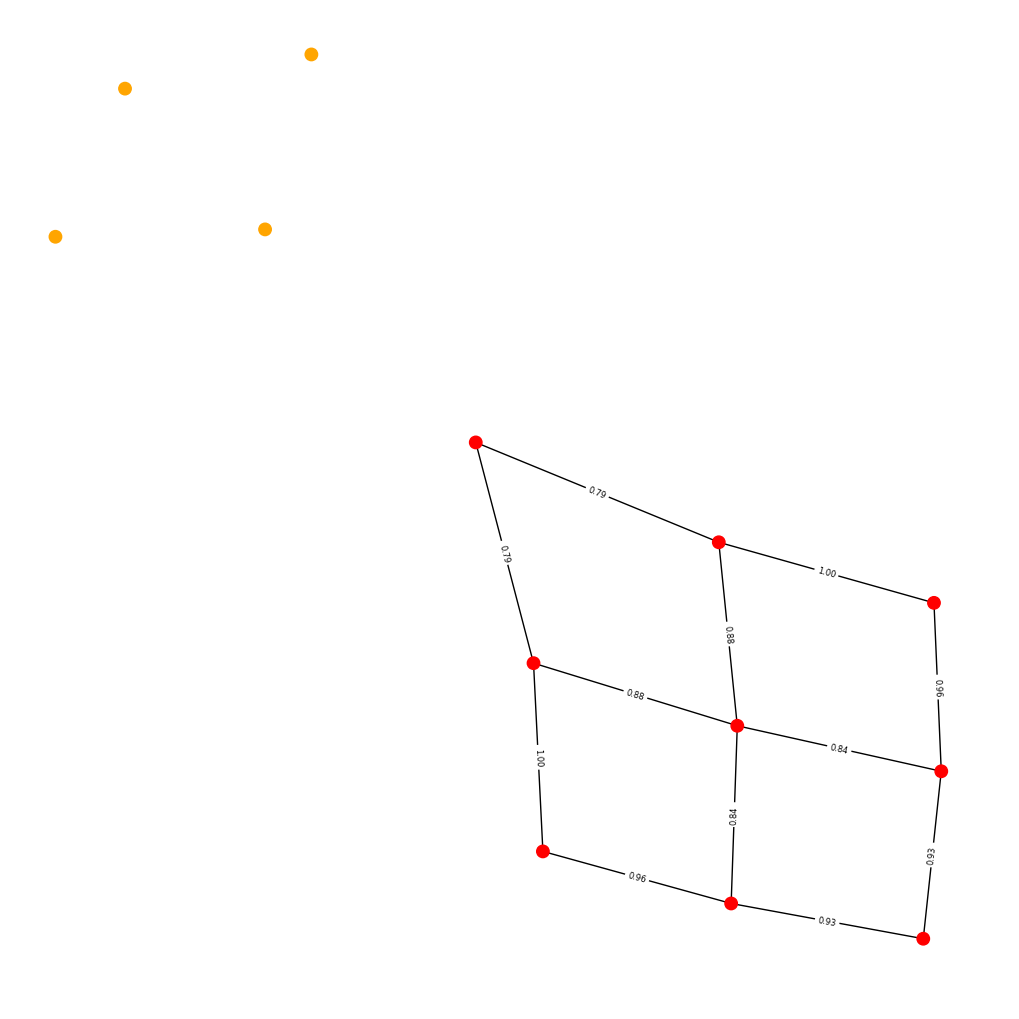

In [200]:
k = 12

mlp.eval()
modelNodeGNN.eval()

#AUCNode = [i for i in range(511,871,6)]
#AUCNode = [i for i in range(a[0].item(),a[len(a)-1]+1,6)]

#print(data.edge_index)

print(evaluation.evaluateNodeExplainerAUC(mlp, modelNodeGNN, data, data.edge_index, currentAUC, data.gt, k=k))

subset, edge_index_hop, mapping, edge_mask = k_hop_subgraph(node_idx=currentAUC, num_hops=3, edge_index=data.edge_index, relabel_nodes=True)

indexNodeToPred = (subset == currentAUC).nonzero().item()

G_hop = Data(x=data.x[subset], edge_index=edge_index_hop, y=data.y[subset])

pos = utils.plotGraphAll(G_hop)




w_ij = mlp.forward(modelNodeGNN, data.x[subset], edge_index_hop, indexNodeToPred)

# Min-Max Normalization. This works pretty well
weights_min = w_ij.min()
weights_max = w_ij.max()
weights_norm = (w_ij - weights_min) / (weights_max - weights_min)

#print(torch.unique(w_ij))
edge_ij = mlp.sampleGraph(w_ij, temperature)

## REMOVE IF SIGMOID WANTED
edge_ij = weights_norm


GraphSampled = Data(x=G_hop.x, edge_index=G_hop.edge_index, y=G_hop.y, edge_attr=edge_ij.detach())

pos = utils.plotGraphAll(GraphSampled, pos, edge_weights=True)


# Print topK edges
k = k * 2 if len(w_ij) >= k*2 else len(w_ij)
_, top_k_indices = torch.topk(edge_ij, k=k, largest=True)

mask = torch.zeros_like(edge_ij, dtype=torch.bool)
mask[top_k_indices] = True

sortedTopK, indices = torch.sort(top_k_indices)

edge_index_masked = G_hop.edge_index[:,mask]
weights_masked = edge_ij[sortedTopK]                # This is ordered by size

GtopK = Data(x=G_hop.x, edge_index=edge_index_masked, y=G_hop.y, edge_attr=weights_masked)

pos1 = utils.plotGraphAll(GtopK, pos=pos, color_map=None, edge_weights=True)

In [214]:
data = datasetLoader.loadOriginalGraphDataset("MUTAG")

In [223]:
train, val, test = datasetLoader.loadGraphDataset("MUTAG")

In [227]:
torch.set_printoptions(threshold=20000)

print(len(train)+len(val)+len(test))
#adj = torch.tensor(data[0])

#edge_index = adj.nonzero().t().contiguous()
#edge_index_undirected = to_undirected(edge_index)
#print(edge_index)

#print(data)

print(data[0].shape)

# features for each node
print(data[1][0].shape)

# Label for each train node
print(data[2].shape)


y_full = torch.zeros_like(torch.tensor(data[2]))
#y_train, y_val, y_test, train_mask, val_mask, test_mask = torch.tensor(data[2]), torch.tensor(data[3]), torch.tensor(data[4]), torch.tensor(data[5]), torch.tensor(data[6]), torch.tensor(data[7])

#y_full[train_mask] = y_train[train_mask]
#y_full[val_mask] = y_val[val_mask]
#y_full[test_mask] = y_test[test_mask]

#print(y_full)

#data = Data(x=data[1],edge_index=edge_index, train_mask=data[5],val_mask=data[6],test_mask=data[7])

4337
(4337, 418, 418)
(418, 14)
(4337, 2)
